In [ ]:
#@title Copyright 2020 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

https://www.tensorflow.org/hub/tutorials/yamnet

https://www.tensorflow.org/tutorials/audio/transfer_learning_audio

- Edited by Justin Blechel

# Sound classification with YAMNet

YAMNet is a deep net that predicts 521 audio event [classes](https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/yamnet_class_map.csv) from the [AudioSet-YouTube corpus](http://g.co/audioset) it was trained on. It employs the
[Mobilenet_v1](https://arxiv.org/pdf/1704.04861.pdf) depthwise-separable convolution architecture.

In this notebook YAMNet is used to classify ABGQI soundscape audio.

TODO: This notebook was not run using colab and will require some edits to get it functioning properly on colab. For example, we must mount the drive and specify the drive location for the wav files.

In [ ]:
# install necessary packages
# !pip install package
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import csv
import scipy
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile
import noisereduce as nr
import torch
import os
import soundfile as sf
from tqdm import tqdm  # Import tqdm for the loading bar

Load the Model from TensorFlow Hub.

Note: to read the documentation just follow the model's [url](https://tfhub.dev/google/yamnet/1)

In [ ]:
# Load the model.
model = hub.load('https://tfhub.dev/google/yamnet/1')

The labels file will be loaded from the models assets and is present at `model.class_map_path()`.
You will load it on the `class_names` variable.

In [ ]:
# extract class names from CSV (Comma-Separated Values) file
# that contains information about the class mapping used by the YAMNet model
def class_names_from_csv(class_map_csv_text):
  """Returns list of class names corresponding to score vector."""
  class_names = []
  with tf.io.gfile.GFile(class_map_csv_text) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      class_names.append(row['display_name'])

  return class_names

class_map_path = model.class_map_path().numpy()
class_names = class_names_from_csv(class_map_path)

Add a method to verify and convert a loaded audio is on the proper sample_rate (16K), otherwise it would affect the model's results.

In [ ]:
def ensure_sample_rate(original_sample_rate, waveform,
                       desired_sample_rate=16000):
  """Resample waveform if required."""
  if original_sample_rate != desired_sample_rate:
    desired_length = int(round(float(len(waveform)) /
                               original_sample_rate * desired_sample_rate))
    waveform = scipy.signal.resample(waveform, desired_length)
  return desired_sample_rate, waveform

## Downloading and preparing the sound file

Here you will download a wav file and listen to it.

If you have a file already available, just upload it to colab and use it instead

Enhance the accuracy of classification in soundscape files by employing a noise reducer to mitigate heavy background noise

Note: The expected audio file should be a mono wav file at 16kHz sample rate.

In [ ]:
# wav_file_name = 'speech_whistling2.wav'
wav_file_name = './newdata/wavs_arbimon_soundscape_composition/s2lam038_230819_2023-08-19_10-00.WAV'
sample_rate, wav_data = wavfile.read(wav_file_name, 'rb')
sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)

duration = len(wav_data)/sample_rate
print(f'Original audio: {wav_file_name} ')
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(wav_data)}')
Audio(wav_data, rate=sample_rate)

Original audio: ./newdata/wavs_arbimon_soundscape_composition/s2lam038_230819_2023-08-19_10-00.WAV 
Sample rate: 16000 Hz
Total duration: 60.00s
Size of the input: 960000


## Reducing Background noise
YAMNet consistently misclassifies heavy background noise as 'Snake' at a significant rate. The issue seems to be mitigated by reducing background noise, which not only eliminates this misclassification but also enhances the accuracy of bird call classification.

Current issue: not classifying vehicle

In [ ]:
# Noise reduction rate
nrr = 0.8

# Optional: reduce background noise
reduced_noise = nr.reduce_noise(y=wav_data, sr=sample_rate, prop_decrease=nrr)

waveform = reduced_noise / tf.int16.max

# Listening to the wav file.
Audio(waveform, rate=sample_rate)

The `wav_data` needs to be normalized to values in `[-1.0, 1.0]` (as stated in the model's [documentation](https://tfhub.dev/google/yamnet/1)).

## Executing the Model

Now the easy part: using the data already prepared, you just call the model and get the: scores, embedding and the spectrogram.

The score is the main result you will use.
The spectrogram you will use to do some visualizations later.

In [ ]:
# Run the model, check the output.
scores, embeddings, spectrogram = model(waveform)

In [ ]:
scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
infered_class = class_names[scores_np.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

The main sound is: Silence


## Visualization

YAMNet also returns some additional information that we can use for visualization.
Let's take a look on the Waveform, spectrogram and the top classes inferred.

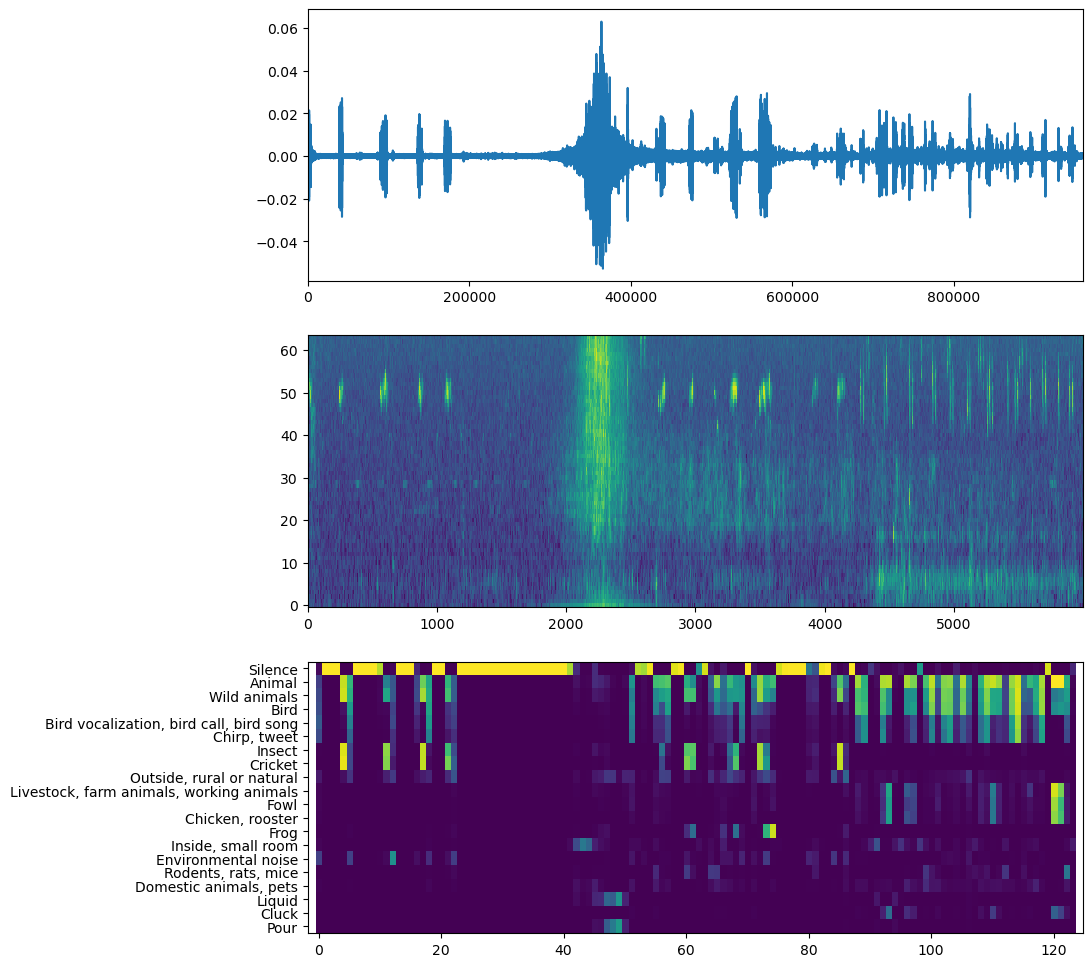

In [ ]:
plt.figure(figsize=(10, 12))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_n = 20
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(3, 1, 3)
plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest')

# patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
# values from the model documentation
patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
# Label the top_N classes.
yticks = range(0, top_n, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))

Now lets set up a simple function to process a wav file

In [ ]:
def process_wav_file(wav_file_path):
    sample_rate, wav_data = wavfile.read(wav_file_path, 'rb')
    sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)

    # Optional: reduce background noise
    reduced_noise = nr.reduce_noise(y=wav_data, sr=sample_rate, stationary=0, prop_decrease=nrr)

    waveform = reduced_noise / tf.int16.max

    # Run the model, check the output.
    scores, _, _ = model(waveform)

    return scores.numpy()

### Mean Aggregation:

In mean aggregation, the model's predictions for each class are averaged over all the frames in the audio. This provides a representation of the average confidence or probability of each class across the entire duration of the audio.

- Useful when you want to capture the overall content or prevalent classes throughout the entire audio clip.
- Effective for scenarios where you are interested in a more generalized understanding of the audio content.

100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [03:47<00:00,  1.67it/s]


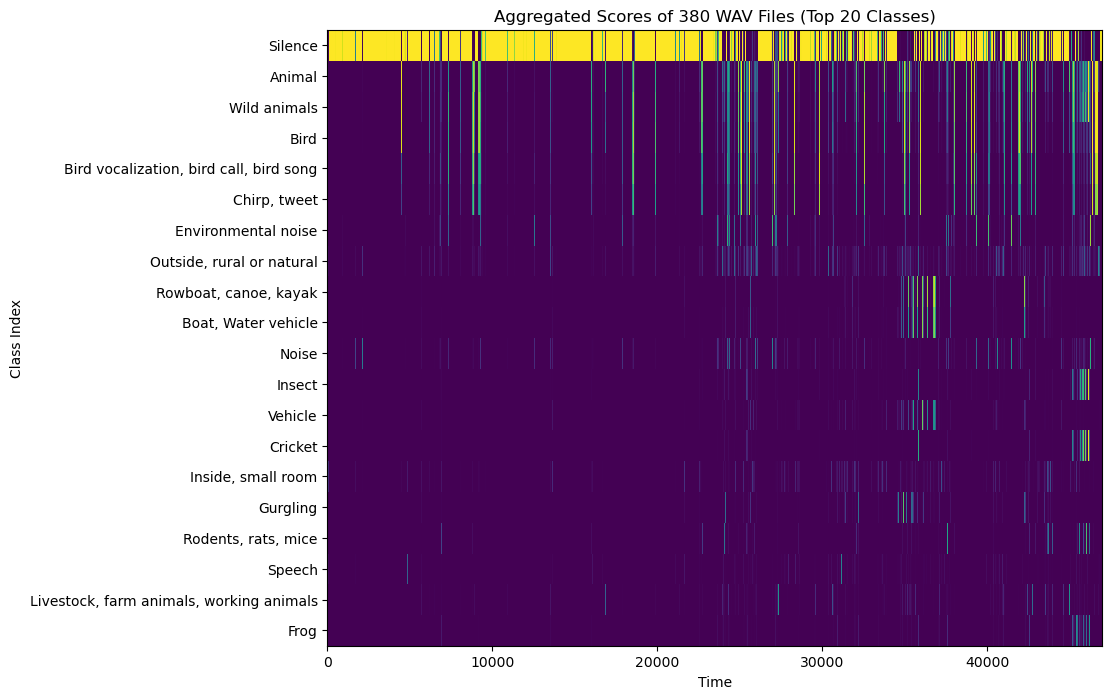

In [ ]:
# Specify the directory containing WAV files
wav_directory = './newdata/wavs_arbimon_soundscape_composition'

# Specify the number of files to process
num_files_to_process = 380  # Change this to the desired number

# Specify the number of top classes to show for all files
num_top_classes = 20  # Change this to the desired number

# Accumulate scores for the specified number of WAV files
all_scores = []

# Get the set of all classes
all_classes = set()

# Iterate through WAV files in the directory up to the specified number
for filename in tqdm(os.listdir(wav_directory)[:num_files_to_process]):
    if filename.endswith(".WAV") or filename.endswith(".wav"):
        wav_file_path = os.path.join(wav_directory, filename)
        scores = process_wav_file(wav_file_path)
        all_scores.append(scores)

# Concatenate all scores along the time axis
concatenated_scores = np.concatenate(all_scores, axis=0)

# Identify the top specified number of classes across all files
top_classes = np.argsort(np.mean(concatenated_scores, axis=0))[::-1][:num_top_classes]



# Plot the final aggregated scores for the specified number of top classes
plt.figure(figsize=(10, 8))
plt.imshow(concatenated_scores[:, top_classes].T, aspect='auto', interpolation='nearest', origin='upper')
plt.title(f'Aggregated Scores of {num_files_to_process} WAV Files (Top {num_top_classes} Classes)')
plt.xlabel('Time')
plt.ylabel('Class Index')
plt.yticks(range(len(top_classes)), [class_names[i] for i in top_classes])
plt.show()

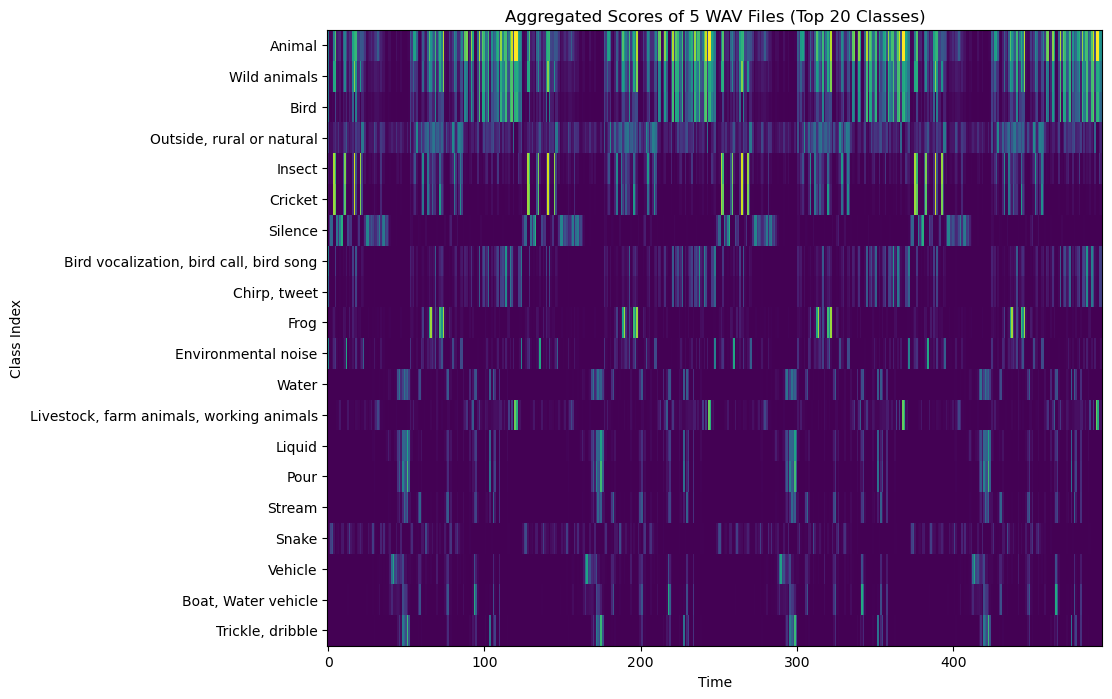

In [ ]:
num_top_classes = 20  # Change this to the desired number
top_classes = np.argsort(np.mean(concatenated_scores, axis=0))[::-1][:num_top_classes]

# Plot the final aggregated scores for the specified number of top classes
plt.figure(figsize=(10, 8))
plt.imshow(concatenated_scores[:, top_classes].T, aspect='auto', interpolation='nearest', origin='upper')
plt.title(f'Aggregated Scores of {num_files_to_process} WAV Files (Top {num_top_classes} Classes)')
plt.xlabel('Time')
plt.ylabel('Class Index')
plt.yticks(range(len(top_classes)), [class_names[i] for i in top_classes])
plt.show()